Author: Chin-Chin Amar
# Manulife Exam

This notebook is presented as follows:

    I. Library and Data Imports
    II. Answers to Guide Questions
        1.1 Give common profiles of users who post and comments in the forum
        1.2 Compare the results between those who post and comments
        2. Are the users who often posts questions also often post answers or comments on the posts of                  others? 
        3. Does a user often post on the same topic?
        4. Additional Analysis

Note: Each Visualizations has takeaway(s) which summarizes the knowledge derived from the data

## I. Library and Data Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import itertools
import collections

plt.style.use("ggplot")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 
%matplotlib inline

In [2]:
users = pd.read_csv("data/Users.csv")
posts = pd.read_csv("data/Posts.csv")
comments = pd.read_csv("data/Comments.csv")
votes = pd.read_csv("data/Votes.csv")
tags = pd.read_csv("data/Tags.csv")
post_history = pd.read_csv("data/PostHistory.csv")
badges = pd.read_csv("data/Badges.csv")
post_links = pd.read_csv("data/PostLinks.csv")

## II. Answers to Guide Questions

### 1.1 Give common profiles of users who post and comments in the forum 

In [3]:
#Identifying users who posts, comments, and does both.
#Note that users in each group is unique for all tables

users_who_post = [user for user in posts['OwnerUserId'].unique()]
users_who_comments = [user for user in comments['UserId'].unique()]
                      
users_both_post_comments = list(set(users_who_post).intersection(users_who_comments))
users_who_post = [user for user in posts['OwnerUserId'].unique() if user not in users_both_post_comments]
users_who_comments = [user for user in comments['UserId'].unique() if user not in users_both_post_comments]

In [4]:
#Creating the profiles of users who posts and comments (cell 4-14)

both_df = pd.DataFrame(data={"Id":users_both_post_comments,"class":"post&comment"})
post_df = pd.DataFrame(data={"Id":users_who_post,"class":"post"})
comment_df = pd.DataFrame(data={"Id":users_who_comments,"class":"comment"})

users_profile_intl = pd.concat([both_df,post_df,comment_df])
#Dropping post or comment without a userId
users_profile_intl.dropna(inplace=True)

In [5]:
#Sanity check. Making sure that there are no duplicate userids.
print("The dataframe has {} rows with {} unique user ids".format(users_profile_intl.shape[0],
                                                            len(users_profile_intl['Id'].unique())))

The dataframe has 21500 rows with 21500 unique user ids


In [6]:
#Taking the users profile from the users dataframe. Specifically the following: Reputation,
# Upvotes, Downvotes, Location, and Creation Date

users_reduced = users[['Id','Reputation','UpVotes','DownVotes','Location','CreationDate']]
users_profile = pd.merge(users_profile_intl,users_reduced,on='Id')


In [7]:
def count_comment_freq(user_id,comments,posts):
    user_comments = comments[comments['UserId']==user_id]
    if len(user_comments)==0:
        return pd.DataFrame(data={"general_comments_freq":0,
            "other_comments_freq":0}, index=[user_id])
    
    else:
        user_post_ids = posts[posts['OwnerUserId']==user_id]['Id'].values
        own_user_comments = list(set(user_comments['PostId'].values).intersection(user_post_ids))

        general_comments_freq = len(user_comments['PostId'].unique())
        other_comments_freq = general_comments_freq - len(own_user_comments)
        
        df = pd.DataFrame(data={"general_comments_freq":general_comments_freq,
            "other_comments_freq":other_comments_freq}, index=[user_id])

        return df
    

In [8]:
# Adding more information on the user_profile. (Frequency of comment, frequency of posts)
frequency_df = pd.concat([x for x in users_profile['Id'].apply(lambda x: count_comment_freq(x,comments,posts))])

In [9]:
frequency_df = frequency_df.reset_index().rename(columns={"index":"Id"})

In [10]:
def count_qa(user_id,posts):
    user_records = posts[posts['OwnerUserId']==user_id]
    user_qa = user_records.groupby("PostTypeId").count()[['Id', 'OwnerUserId', 'ParentId']]
    
    q = 1 if 1 in user_qa['Id'].values else 0
    a = 1 if 2 in user_qa['Id'].values else 0

    
    return pd.DataFrame({"Id":[user_id], "QuestionFlag":[q], "AnswerFlag":[a]})
    

In [11]:
qa_df = pd.concat([x for x in frequency_df['Id'].apply(lambda x: count_qa(x, posts))])

In [12]:
def simplify_location(x):
    location = x['Location'].values[0].split(",")[-1]
    if location.strip()=="United States":
        location="USA"
    if location.strip()=="United Kingdom":
        location = "UK"
    x['Location'] = location.strip()
    return x

In [13]:

additional_details = pd.merge(frequency_df,qa_df, on='Id')
users_profile_fin = pd.merge(users_profile, additional_details, on='Id')

# Formatting Location down to the most general detail
# example: Paris, France -> France
users_profile_fin['Location'].fillna("None", inplace=True)
users_profile_fin = users_profile_fin.groupby("Location").apply(lambda x: simplify_location(x))

In [14]:
#Here's our final user profiles and we'll work from here.
users_profile_fin

,Id,class,Reputation,UpVotes,DownVotes,Location,CreationDate,general_comments_freq,other_comments_freq,QuestionFlag,AnswerFlag
0,98304.0,post&comment,123,1,0,None,2020-06-01T10:12:32.143,1,1,1,0
1,65538.0,post&comment,103,1,0,Sweden,2019-01-08T14:19:46.927,1,1,1,0
2,32771.0,post&comment,53,0,0,India,2017-05-29T07:23:20.207,1,0,1,0
3,65541.0,post&comment,41,0,0,None,2019-01-08T14:40:34.663,2,1,0,0
4,11.0,post&comment,213,10,0,Dubai - United Arab Emirates,2014-05-13T23:20:53.387,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...
21495,50168.0,comment,101,3,0,NY,2018-04-08T16:17:23.000,1,1,0,0
21496,30905.0,comment,101,5,0,USA,2017-04-08T21:28:24.830,1,1,0,0
21497,62558.0,comment,101,11,0,USA,2018-11-14T03:11:20.473,1,1,0,0
21498,112473.0,comment,101,0,0,Nepal,2021-02-26T07:47:45.803,1,1,0,0


## 1.2 Compare the results between those who posts and comments

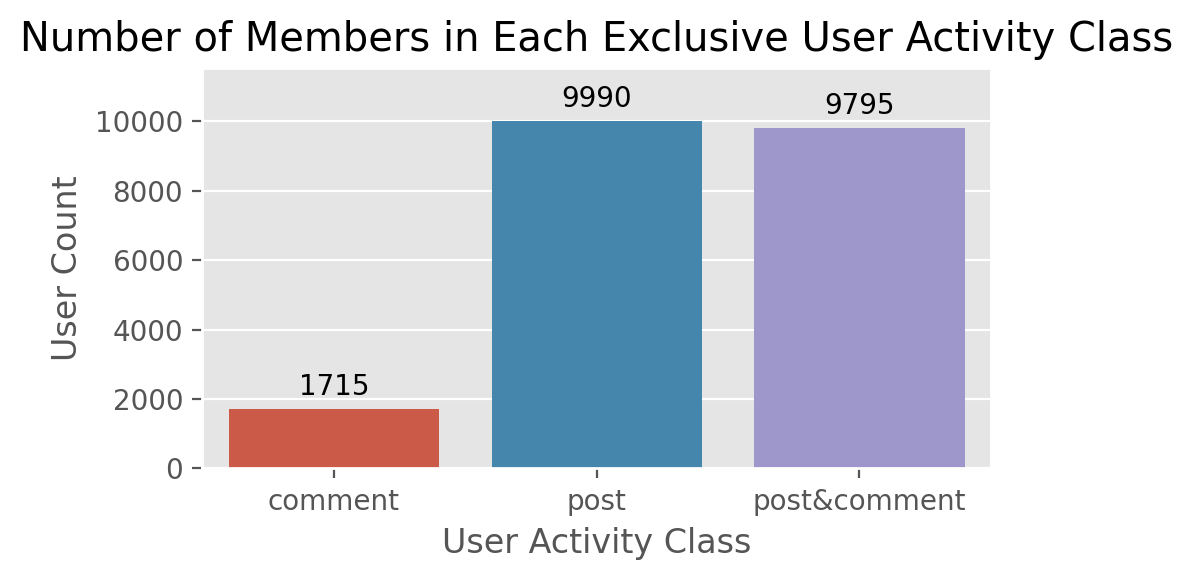

In [15]:
plt.figure(figsize=(5,3),dpi=200)
population = users_profile_fin.groupby("class").count()[['Id']].reset_index()
plot = sb.barplot(x="class",y="Id",data=population)
for bar in plot.patches:
    plot.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
bottom, top = plt.ylim()
plt.ylim(bottom,top+(top*0.1))
plt.xlabel("User Activity Class")
plt.ylabel("User Count")
plt.title("Number of Members in Each Exclusive User Activity Class")
plt.tight_layout()
plt.show()

#### Take aways:
    * The plot above shows that there are almost thesame number of users who post  and those who writes           both posts and comments.
    * Moreover, only about 8% of the entire population has written comment(s) alone.

### Trend of new users for each user class activity (post, comment, post&comment)

In [16]:
users_profile_fin['CreationYear']=pd.to_datetime(users_profile_fin['CreationDate']).dt.year
user_reg_count = users_profile_fin.groupby(["class","CreationYear"]).\
                    apply(lambda x: x.count())[['Id']].reset_index()
user_reg_count.head()

,class,CreationYear,Id
0,comment,2014,88
1,comment,2015,118
2,comment,2016,179
3,comment,2017,274
4,comment,2018,404


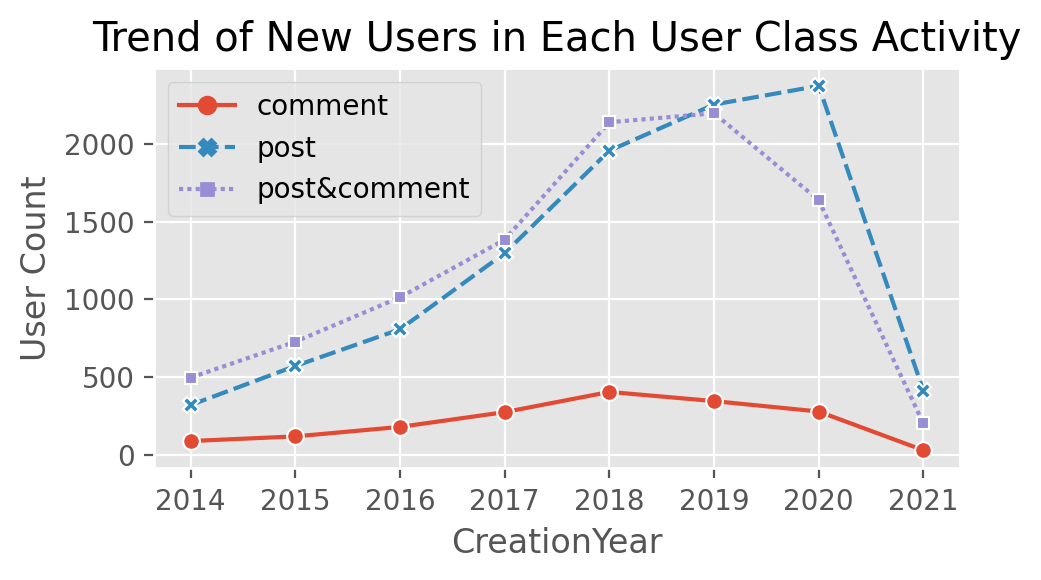

In [17]:
plt.figure(figsize = (5,3),dpi=200)
sb.lineplot(x = "CreationYear", y="Id", hue="class", style="class", markers=True, data = user_reg_count)
plt.legend()
plt.title("Trend of New Users in Each User Class Activity")
plt.ylabel("User Count")
plt.tight_layout()
plt.show()

#### In the plot above, we can see the trend in the number of newly created user accounts in each of the user class activity, namely the comment, post, and post&comment. The following are some valuable takeaways:


    * There is a continuous increase in the population of the users that writes posts alone. 
    * The sudden drop in user registrations per class in the year 2021 is not unusual since 
        we are still halfway through the year. 
    * Each class has different peaks. 2020 for the post class, 2019 for the post&comment class,
        and 2018 for the comment class. So relatively, the post class has the highest number of 
        new users.

### Locations of users in each user class activity 

In [18]:
user_loc = users_profile_fin.groupby(['class','Location']).apply(lambda x: x.count())[['Id']].\
            reset_index()
user_loc = user_loc[user_loc['Location']!="None"].set_index("Location")
user_loc = user_loc.groupby(["class"],axis=0,as_index=False).\
            apply(lambda x: x.sort_values("Id",ascending=False).head(5)).reset_index()
user_loc.drop("level_0",axis=1,inplace=True)

In [19]:
def color_assign(countries):
    color_dict = {"USA":"#E24A33","UK":"#348ABD","India":"#988ED5","Germany":"#777777","France":"#FBC15E",
                 "Canada":"#8EBA42"}
    colors = [color_dict[c] for c in countries]
    return colors

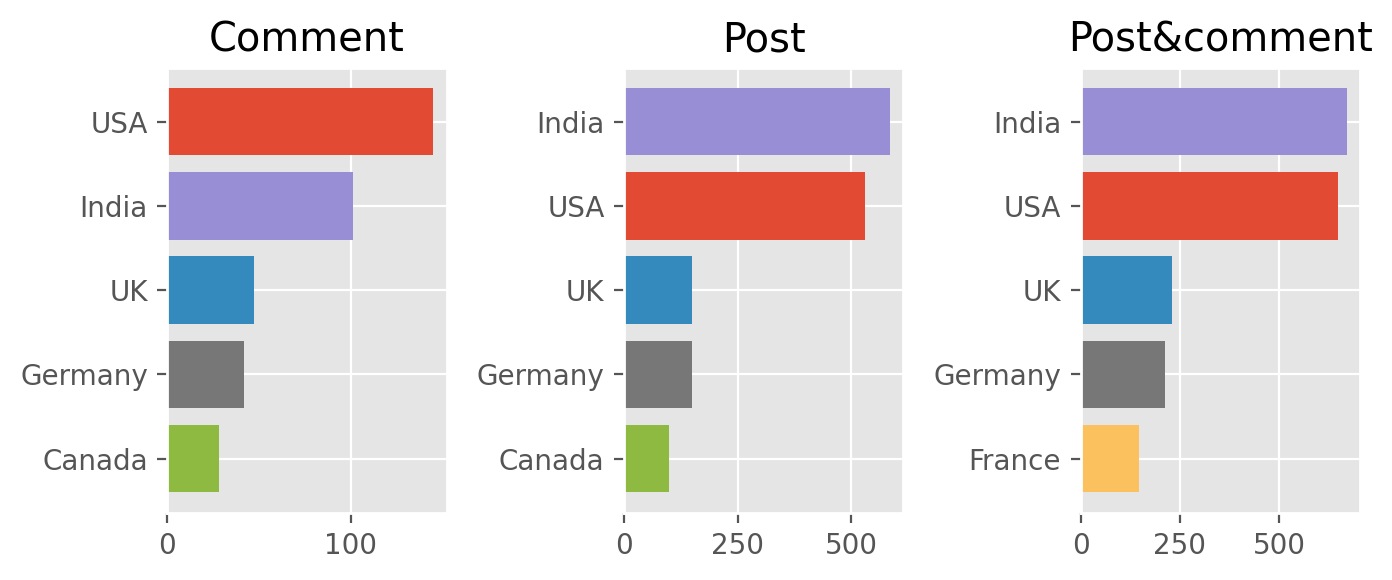

In [20]:
user_classes = user_loc['class'].unique()
fig, axes = plt.subplots(1,3,figsize=(7,3),dpi=200)
ax = axes.flatten()

for i, class_name in enumerate(user_classes):
    df = user_loc[user_loc['class']==class_name].sort_values("Id",ascending=True)
    ax[i].barh(df['Location'],df['Id'], align='center', color=color_assign(df['Location']))
    ax[i].set_title("{}".format(class_name.capitalize()))
plt.tight_layout()
plt.show()

#### Take aways:

    * The top 4 countries with the most number of users are consistent across the user activity classes              with India and US switching between the first and second most users. 

### Reputation Scores

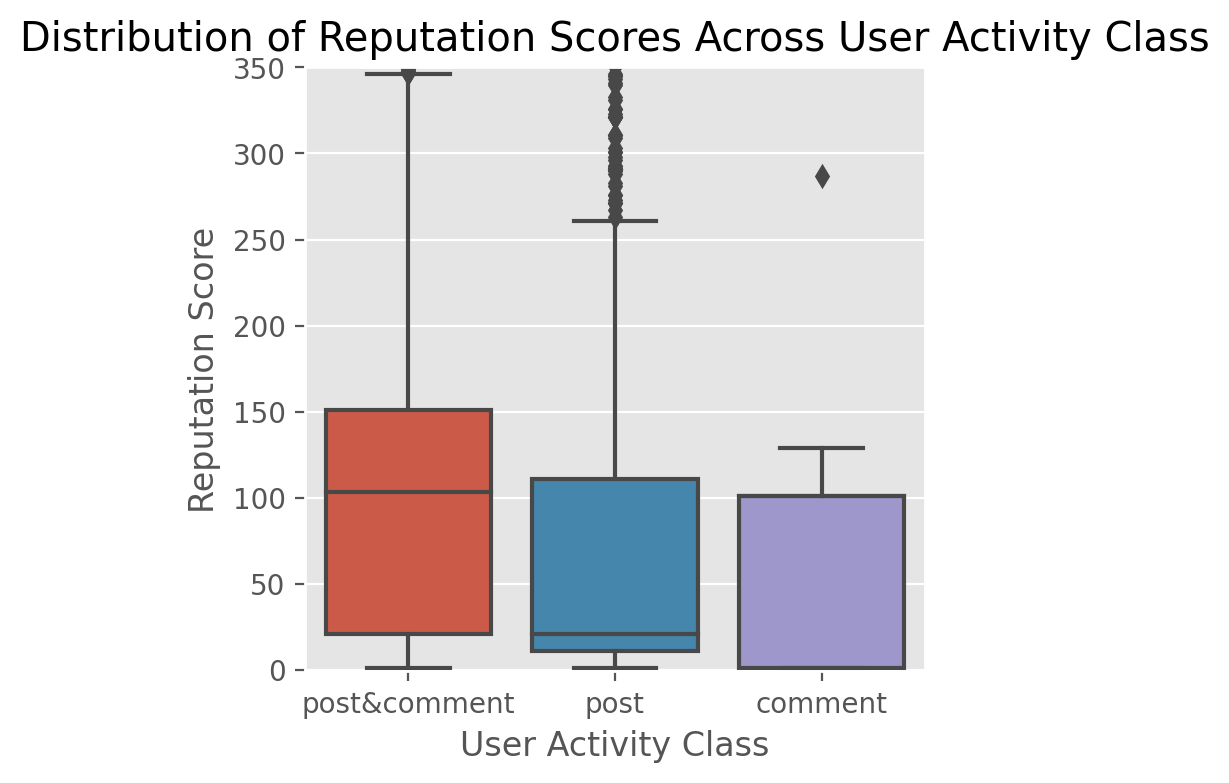

In [21]:
plt.figure(figsize=(4,4),dpi=200)
sb.boxplot(x="class",y="Reputation", data=users_profile_fin)
plt.ylim(-1,350)
plt.ylabel("Reputation Score")
plt.xlabel("User Activity Class")
plt.title("Distribution of Reputation Scores Across User Activity Class")
plt.show()

#### Take aways:

    * Reputation scores are relatively higher on users that writes both posts and comments compared to those who post or comment alone.
    * There were a lot of outliers in the repution scores of all three user activity class

## 2. Are the users who often posts questions also often post answers or comments on the posts of others?

For this question, I focused more on the users that both writes post and comment. So for this, we have 9,795 unique users

In [22]:
users_df = users_profile_fin[users_profile_fin['class']=='post&comment']
users_df.head()

,Id,class,Reputation,UpVotes,DownVotes,Location,CreationDate,general_comments_freq,other_comments_freq,QuestionFlag,AnswerFlag,CreationYear
0,98304.0,post&comment,123,1,0,None,2020-06-01T10:12:32.143,1,1,1,0,2020
1,65538.0,post&comment,103,1,0,Sweden,2019-01-08T14:19:46.927,1,1,1,0,2019
2,32771.0,post&comment,53,0,0,India,2017-05-29T07:23:20.207,1,0,1,0,2017
3,65541.0,post&comment,41,0,0,None,2019-01-08T14:40:34.663,2,1,0,0,2019
4,11.0,post&comment,213,10,0,Dubai - United Arab Emirates,2014-05-13T23:20:53.387,2,2,1,1,2014


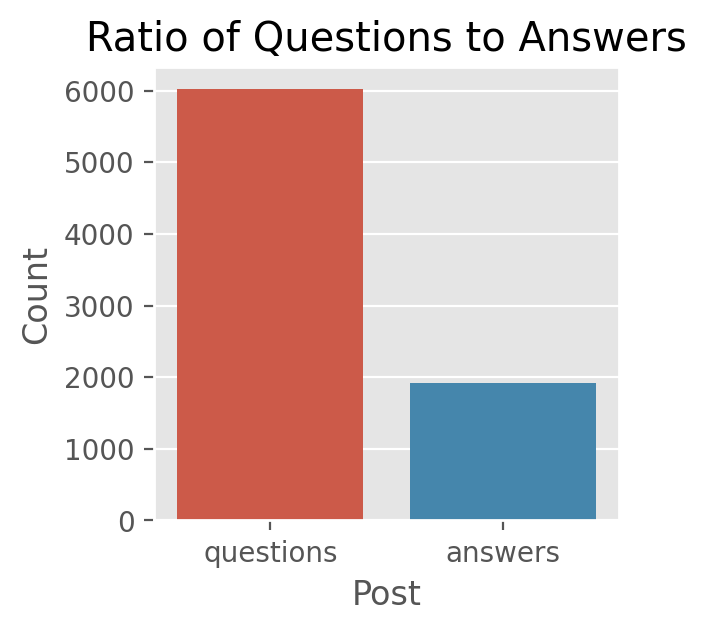

In [23]:
#Ratio of users who post either questions and answers

users_q_count = users_df['QuestionFlag'].sum()
users_a_count = users_df['AnswerFlag'].sum()

qa_ratio = pd.DataFrame({"Post":["questions","answers"],"Count":[users_q_count,users_a_count]})

plt.figure(figsize = (3,3), dpi=200)
sb.barplot(x="Post", y="Count", data = qa_ratio)
plt.title("Ratio of Questions to Answers")
plt.show()

In [24]:
users_q_count/(users_q_count+users_a_count)

0.7589161940768746

#### Take aways:

    * 76% of the posts that users write are questions. Only the remaining 24% are answers.

#### How many members who writes questions give comments to others?

<ipython-input-25-4b81c5f98728>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  users_comment_others_count = users_comment_others_count[users_df['QuestionFlag']==1].shape[0]


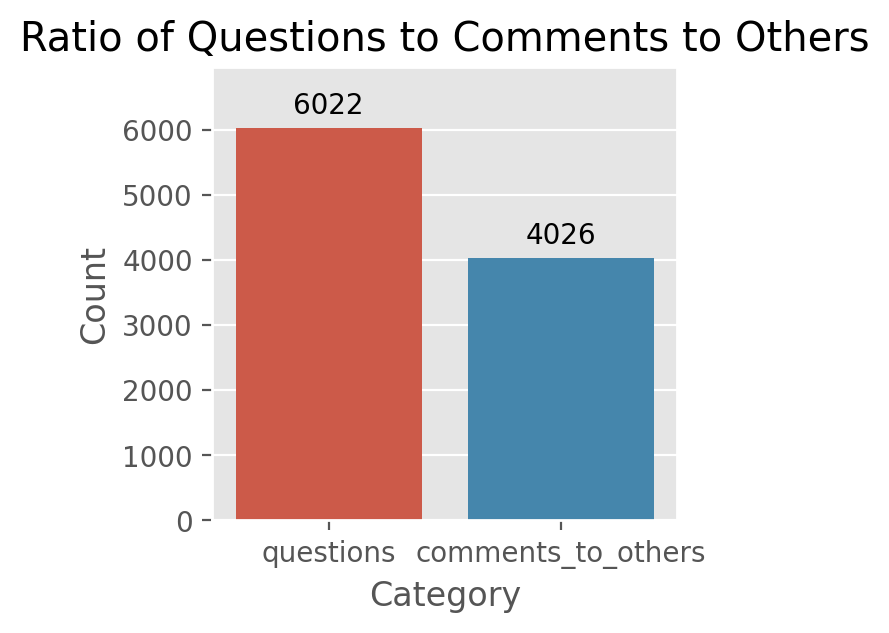

In [25]:
users_comment_others_count = users_df[users_df['other_comments_freq']>0]
users_comment_others_count = users_comment_others_count[users_df['QuestionFlag']==1].shape[0]
qc_ratio = pd.DataFrame({"Category":["questions","comments_to_others"],
                         "Count":[users_q_count,users_comment_others_count]})

plt.figure(figsize = (3,3), dpi=200)
plot=sb.barplot(x="Category", y="Count", data = qc_ratio)

for bar in plot.patches:
    plot.annotate("{}".format(format(bar.get_height(),'.0f')), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()),
                   ha='center', 
                   va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
bottom, top = plt.ylim()
plt.ylim(bottom,top+(top*0.1))
plt.title("Ratio of Questions to Comments to Others")
plt.show()

#### Take aways:
    
    * 67% of the users who posts a question usually writes a comment to other users.

## 3. Does a user often post on the same topic?  

For this one, we will only look at users who either just posts, or does both post and comment

In [26]:
users_df = users_profile_fin[users_profile_fin['class'].isin(['post','post&comment'])]
user_ids = users_df['Id'].values

In [27]:
##**** this could be translated to sql

users_posts_tags = posts[posts['OwnerUserId'].isin(user_ids)][['OwnerUserId','Tags']]
users_posts_tags.head(4)

,OwnerUserId,Tags
0,5.0,<machine-learning>
1,36.0,<education><open-source>
2,51.0,NaN
3,22.0,NaN


In [28]:
users_posts_tags.dropna(subset=['Tags'], inplace=True)
users_posts_tags['Tags'] = users_posts_tags["Tags"].head().\
                            apply(lambda x: [x for x in re.split('<|>',x) if x!=""])
users_posts_tags.head(3)

,OwnerUserId,Tags
0,5.0,[machine-learning]
1,36.0,"[education, open-source]"
4,66.0,"[data-mining, definitions]"


In [29]:
def count_tags(row):
    #This function counts the number of occurence of a particular tag in each user
    
    user_id = row['OwnerUserId']
    tags = row['Tags']
    tags = [t for t in tags if str(t)!='nan']
    len_tags = len(tags)
    list_tags = []
    for i in range(len_tags):
        list_tags+=tags[i]
    list_tags = [(l.strip()).lower() for l in list_tags]
    if len_tags!=0:
        max_topic_freq = max(collections.Counter(list_tags).values())
    else:
        max_topic_freq=0
    
    return pd.DataFrame({'no_of_tags':[len(list_tags)],'max_topic_freq':[max_topic_freq]})

    

In [30]:
user_tags_freq = users_posts_tags.sort_values("OwnerUserId").groupby("OwnerUserId").\
                apply(lambda x: count_tags(x))

In [31]:
max(user_tags_freq['max_topic_freq'])

1

#### Take aways:

    * There has been very little rows in our cohort that has tags values within their post.
    * Most of the values were "nan"
    * Among those that has tags, the topics that a user posts about are different. There hasn't been any            instance that a user posted on the same topic.

### 4. Additional Analysis

##### General Exploratory Data Analysis

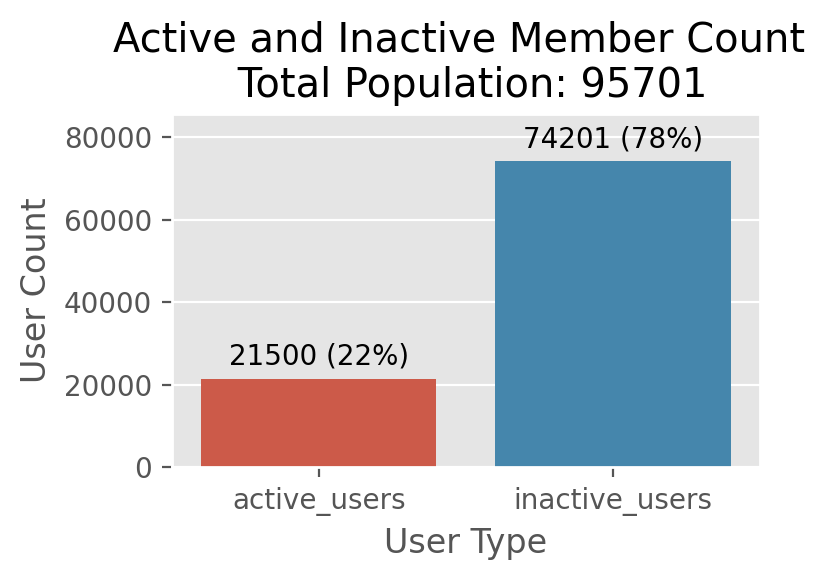

In [32]:
# Here, we look at the ratio of users who are active, meaning they either write a post or a comment or both, 
# and those that are inactive: users that doesn't have any post or comment record.

total_users = users.shape[0]
active_users = users_profile_fin.shape[0]
inactive_users = total_users-active_users
pop_df = pd.DataFrame({"group":["active_users","inactive_users"],"count":[active_users,inactive_users]})

plt.figure(figsize=(4,3),dpi=200)
plot = sb.barplot(x="group",y="count",data=pop_df)
for bar in plot.patches:
    plot.annotate("{} ({}%)".format(format(bar.get_height(),'.0f'),
                                  format((bar.get_height()/total_users)*100,'.0f')), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()),
                   ha='center', 
                   va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
bottom, top = plt.ylim()
plt.ylim(bottom,top+(top*0.1))
plt.xlabel("User Type")
plt.ylabel("User Count")
plt.title("Active and Inactive Member Count \n Total Population: {}".format(total_users))
plt.tight_layout()
plt.show()

#### As shown in the plot above, only 21,500 (22%) of the users are active. In this case, we define active as users who either post or comment or both.  

Trends of posts across years

<ipython-input-33-9102a1e07aaa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_details['CreationYear']=pd.to_datetime(posts_details['CreationDate']).dt.year


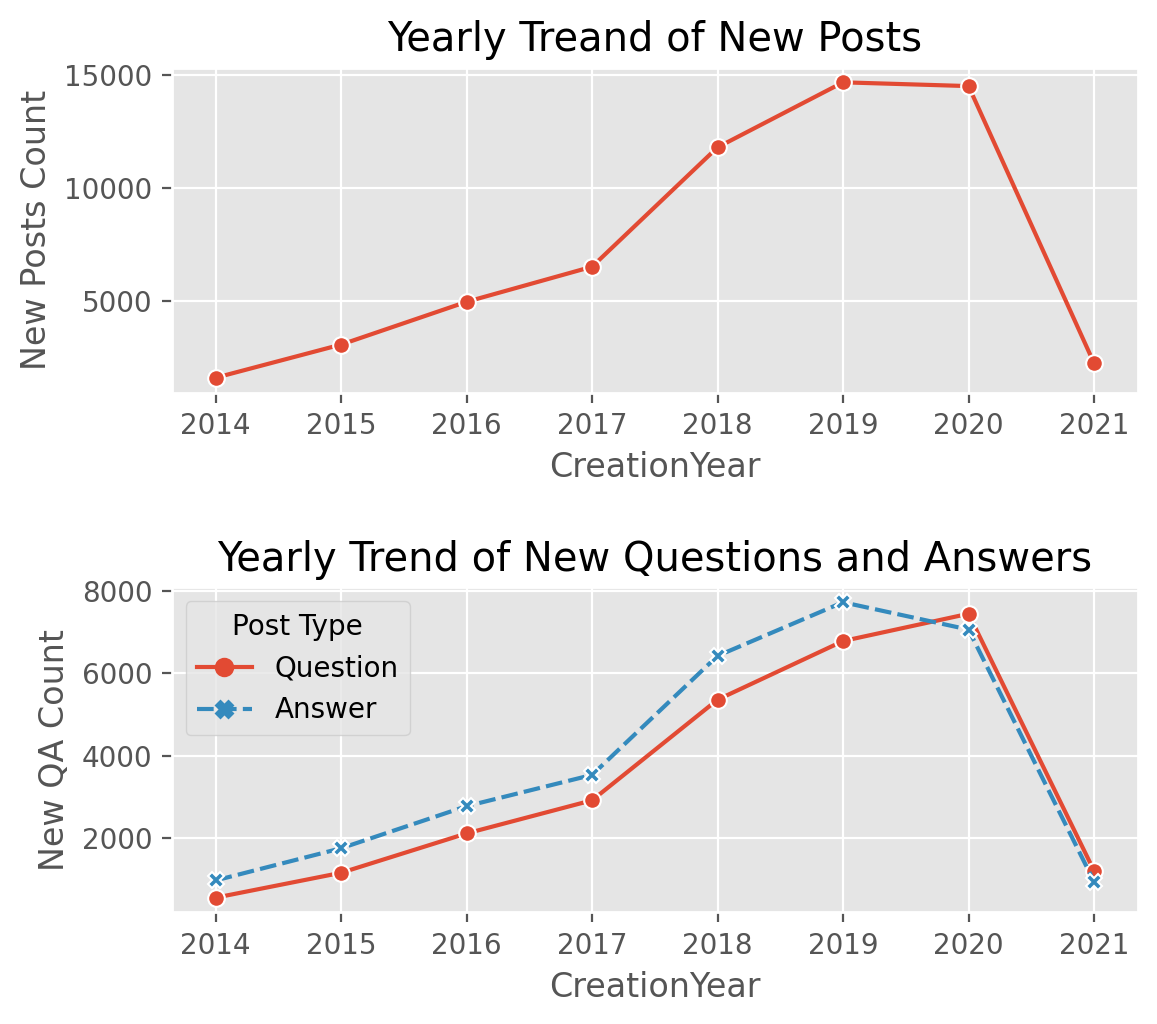

In [33]:
posts_details = posts[['Id','CreationDate', 'PostTypeId']]
posts_details

fig, axes = plt.subplots(2,1, figsize=(6,5),dpi=200)
ax = axes.flatten()


#---Upper Plot---
posts_details['CreationYear']=pd.to_datetime(posts_details['CreationDate']).dt.year
posts_year_counts = posts_details.groupby(["CreationYear"]).\
                    apply(lambda x: x.count())[['Id']].reset_index()

posts_year_counts['class']="post"
sb.lineplot(x="CreationYear", y="Id", data = posts_year_counts, ax=ax[0], style="class", markers=True,
           legend=False)
ax[0].set_ylabel("New Posts Count")
ax[0].set_title("Yearly Treand of New Posts")
plt.tight_layout()

#---Lower Plot---
qa_year_counts = posts_details.groupby(['PostTypeId','CreationYear']).\
                    apply(lambda x: x.count())[['Id']].reset_index()
qa_year_counts['Post Type'] = ["Question" if x==1 else\
                               ("Answer" if x==2 else None) for x in qa_year_counts['PostTypeId']]
sb.lineplot(x="CreationYear", y="Id", hue="Post Type", data=qa_year_counts,
            style="Post Type",markers=True, ax=ax[1])
ax[1].set_ylabel("New QA Count")
ax[1].set_title("Yearly Trend of New Questions and Answers")

plt.subplots_adjust(hspace=0.6)
plt.show()


Take aways:
    
    * A constant upward trend could be observed on the number of new posts from 2014-2015
    * A steep increase in new posts happened from 2017-2018, both for questions and answers, and peaked at 2019
    * A change in trend can be observed from 2019-2020. 
    * The possible reason for the said decrease could be seen in the next plot. Despite the increase in questions, somw users stopped posting answers.
    * The drasatic decrease in the year 2021 is predictable since we are only halfway though the year.  

### Locations

In [34]:
# locations = user_profile_fin[user_profile_fin]
locations = users_profile_fin.groupby("Location").count()[['Id']].\
            sort_values("Id",ascending=False).reset_index()
locations = locations[locations['Location']!='None'].head(10)

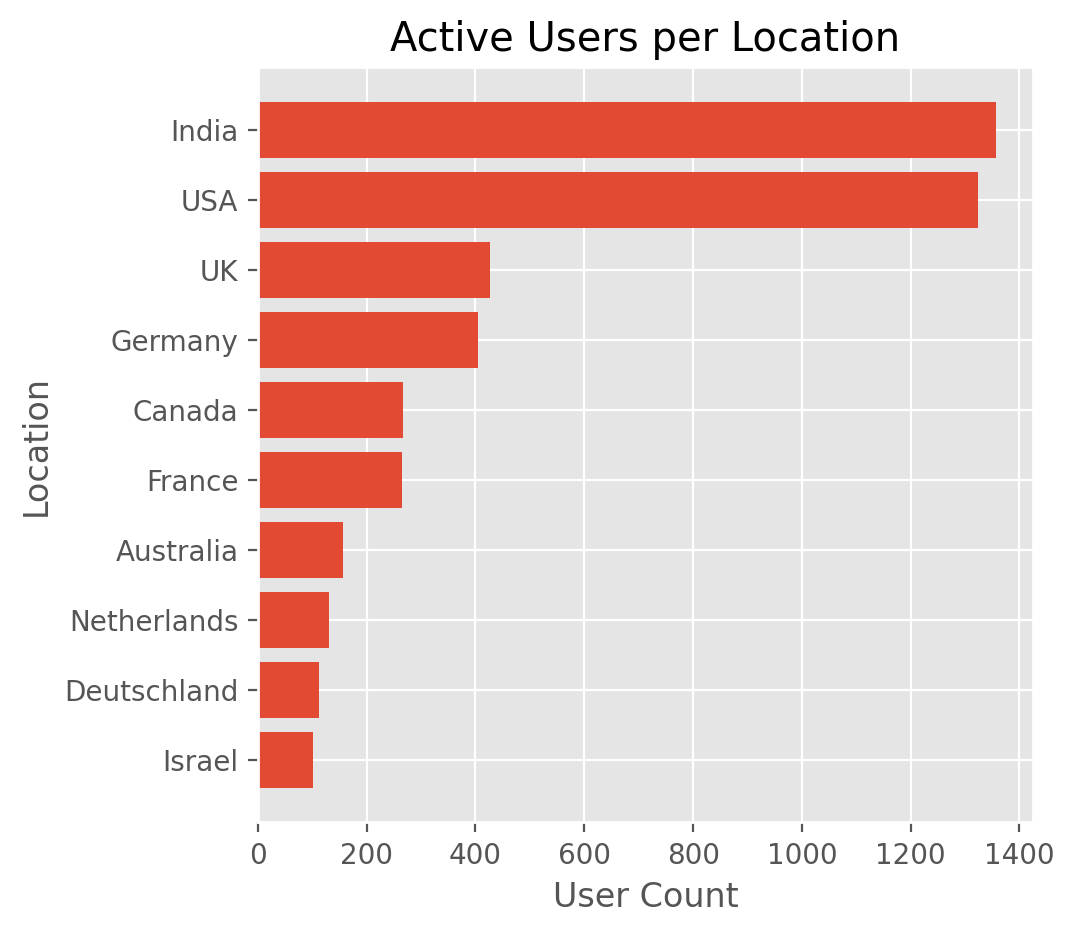

In [35]:
plt.figure(figsize=(5,5), dpi=200)
locations.sort_values("Id", inplace=True)
plt.barh(locations['Location'], locations['Id'])
plt.xlabel("User Count")
plt.ylabel("Location")
plt.title("Active Users per Location")
plt.show()

#### Take aways:

    * There is a close gap between the number of users in India and USA though India ranks first.
    * Aside from India, no other Asian countries belonged to the top 10 countries with the most number of users.

### Reputation Scores per Location (Top 5 highest user count)

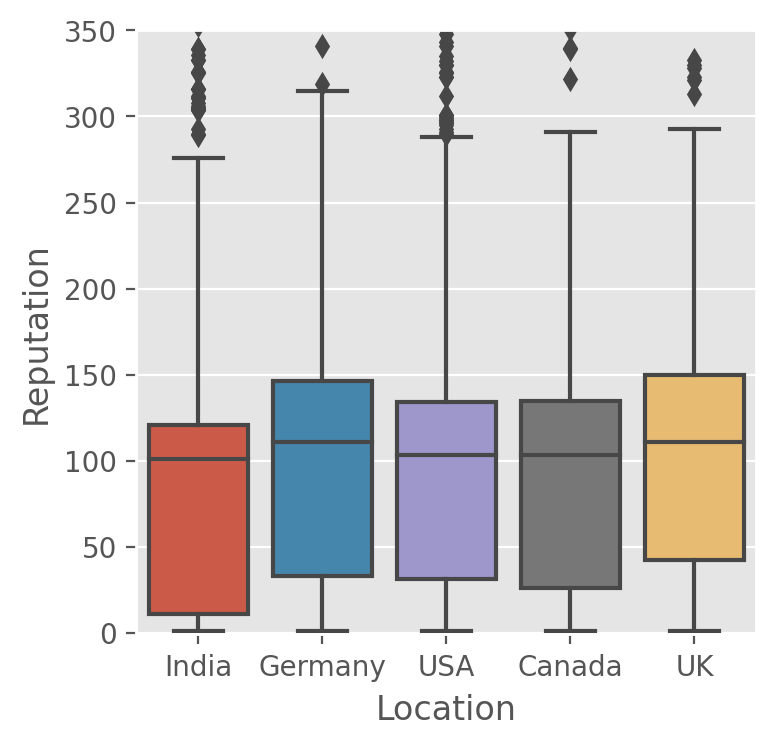

In [36]:
location_names = locations.sort_values("Id", ascending=False).head(5)['Location'].values
top_locations=users_profile_fin[users_profile_fin['Location'].isin(location_names)]

plt.figure(figsize=(4,4), dpi=200)
sb.boxplot(x="Location", y="Reputation", data=top_locations)
plt.ylim(-1,350)
plt.show()

#### Take aways:
    
    * Despite India being the country with the highest number of users, there median reputation score including the lower quartile of their reputation score is the lowest among the top 5 countries.

#### Author's Note

I haven't had the opportunity to perform the data wrangling part in SQL as I find it rather convinient and easier to do it in python instead. On top of that, I don't have an access to a free cloud database and I had a hard time setting up the database locally. Though, I am well aware that it is a must, I am still looking forward for your consideration :) Though if not, I am still thankful for the opportunity. I really enjoyed this exam. Thank you!